In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:2


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [5]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

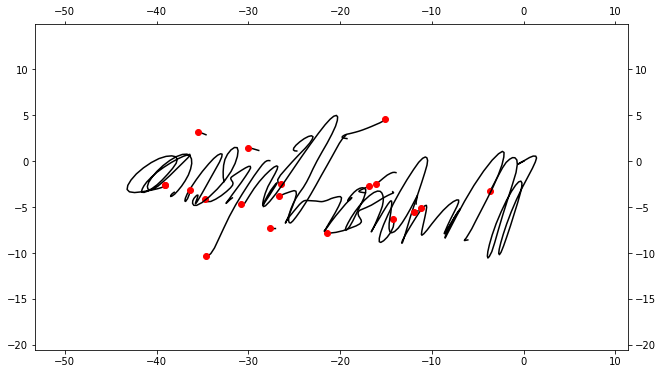

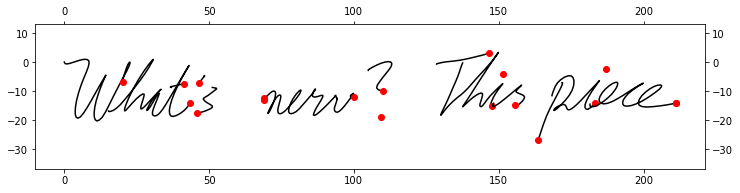

What 's new? This piece


In [8]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        #self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx] #, self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [10]:
class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(input_size+hidden_size, output_size)
        
    def forward(self, packed_input, h0, c0):
        packed_out1, (hn, cn) = self.lstmLayer(packed_input, (h0, c0))
        
        lin_layer_input = torch.cat(
            (packed_input.data, packed_out1.data), dim=-1)
        return self.linearLayer(lin_layer_input), (hn, cn)

In [11]:
def get_mixture_params_from_output(outputs):
    pis = nn.Softmax(1)(outputs[:,:n_mixtures])
    mus = outputs[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    
    sigmas = torch.exp(outputs[:, 3*n_mixtures:5*n_mixtures]).reshape(-1, n_mixtures, 2)
    phos = torch.tanh(outputs[:, 5*n_mixtures:6*n_mixtures]).reshape(-1, n_mixtures, 1)
    
    covs = torch.zeros(outputs.shape[0], n_mixtures, 2, 2, device=device)
    covs[:,:,0,0] = sigmas[:,:,0]**2
    covs[:,:,1,1] = sigmas[:,:,1]**2
    covs[:,:,0,1] = phos[:,:,0] * sigmas[:,:,0] * sigmas[:,:,1]
    covs[:,:,1,0] = covs[:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,-1]))

def nll(outputs, targets):
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords)
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=1)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    
    return loss_per_point.sum()/batch_size

In [12]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        model_input = pack_padded_sequence(
            point_prev.unsqueeze(0).unsqueeze(0),
            torch.tensor([1]).cpu().numpy(),
            batch_first=True)
        outputs, (h_next, c_next) = model(model_input, h_prev, c_prev)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [13]:
def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    lengths_batch, perm_idx = lengths_batch.sort(0, descending=True)
    strokes_batch = strokes_batch[perm_idx]
    
    packed_inputs = pack_padded_sequence(
        strokes_batch,
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    targets = pack_padded_sequence(
        strokes_batch[:,1:,:],
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    return packed_inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    loss = nll(outputs, targets.data)
    loss.backward()
    #### Do Gradient clipping here if need be
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                h0, c0)
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                sample_stroke = sample(model)
                sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [14]:
n_mixtures = 1
hidden_size = 500
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 0.00001
model_name = "20210808_prediction_model_with_many_fixes"

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


iteration: 0 of 39000, avg_loss: 42.47, timeSinceStart: 2.23, Epoch: 0


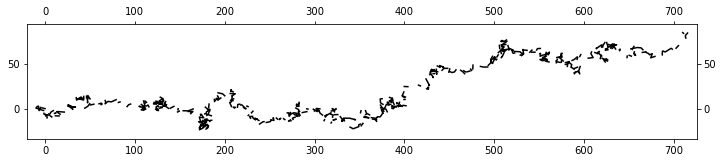

iteration: 50 of 39000, avg_loss: 2110.20, timeSinceStart: 18.17, Epoch: 1
iteration: 100 of 39000, avg_loss: 2091.12, timeSinceStart: 32.47, Epoch: 2
iteration: 150 of 39000, avg_loss: 2069.65, timeSinceStart: 46.83, Epoch: 3
iteration: 200 of 39000, avg_loss: 2039.67, timeSinceStart: 61.22, Epoch: 5
iteration: 250 of 39000, avg_loss: 1982.85, timeSinceStart: 75.64, Epoch: 6


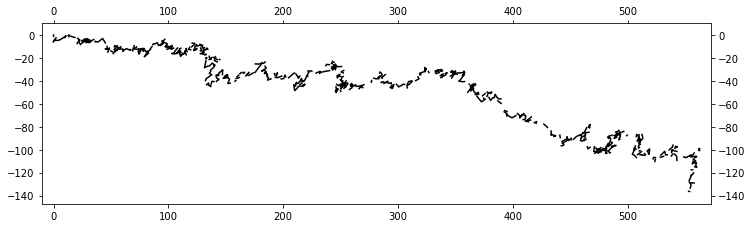

iteration: 300 of 39000, avg_loss: 2381.81, timeSinceStart: 91.67, Epoch: 7
iteration: 350 of 39000, avg_loss: 1900.85, timeSinceStart: 106.13, Epoch: 8
iteration: 400 of 39000, avg_loss: 1903.39, timeSinceStart: 120.59, Epoch: 10
iteration: 450 of 39000, avg_loss: 1888.67, timeSinceStart: 135.00, Epoch: 11
iteration: 500 of 39000, avg_loss: 1886.69, timeSinceStart: 149.45, Epoch: 12


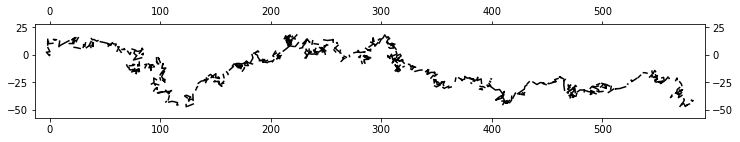

iteration: 550 of 39000, avg_loss: 1883.89, timeSinceStart: 165.52, Epoch: 14
iteration: 600 of 39000, avg_loss: 1875.70, timeSinceStart: 179.89, Epoch: 15
iteration: 650 of 39000, avg_loss: 1872.56, timeSinceStart: 194.38, Epoch: 16
iteration: 700 of 39000, avg_loss: 1872.75, timeSinceStart: 208.82, Epoch: 17
iteration: 750 of 39000, avg_loss: 1863.18, timeSinceStart: 223.19, Epoch: 19


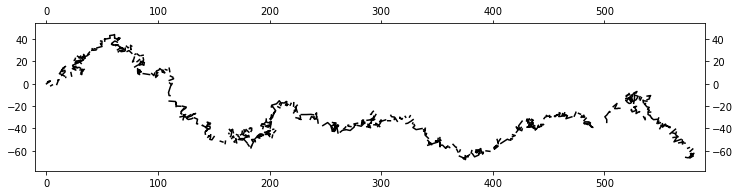

iteration: 800 of 39000, avg_loss: 1859.36, timeSinceStart: 239.44, Epoch: 20
iteration: 850 of 39000, avg_loss: 1860.32, timeSinceStart: 253.92, Epoch: 21
iteration: 900 of 39000, avg_loss: 1849.78, timeSinceStart: 268.42, Epoch: 23
iteration: 950 of 39000, avg_loss: 1850.10, timeSinceStart: 282.90, Epoch: 24
iteration: 1000 of 39000, avg_loss: 1841.89, timeSinceStart: 297.45, Epoch: 25


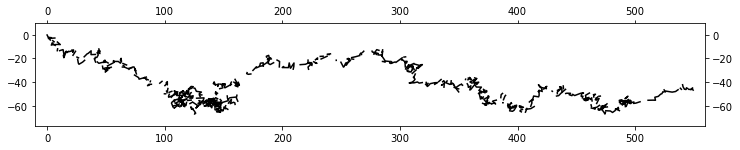

iteration: 1050 of 39000, avg_loss: 1841.22, timeSinceStart: 313.43, Epoch: 26
iteration: 1100 of 39000, avg_loss: 1834.26, timeSinceStart: 327.89, Epoch: 28
iteration: 1150 of 39000, avg_loss: 1834.98, timeSinceStart: 342.34, Epoch: 29
iteration: 1200 of 39000, avg_loss: 1821.94, timeSinceStart: 356.73, Epoch: 30
iteration: 1250 of 39000, avg_loss: 1819.75, timeSinceStart: 371.19, Epoch: 32


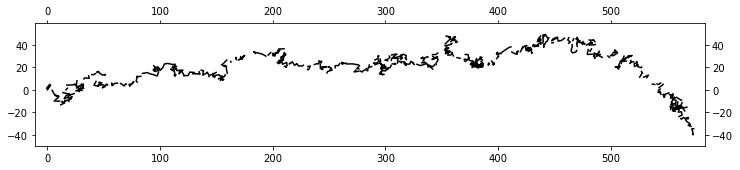

iteration: 1300 of 39000, avg_loss: 1811.95, timeSinceStart: 387.20, Epoch: 33
iteration: 1350 of 39000, avg_loss: 1812.91, timeSinceStart: 401.62, Epoch: 34
iteration: 1400 of 39000, avg_loss: 1807.94, timeSinceStart: 416.05, Epoch: 35
iteration: 1450 of 39000, avg_loss: 1801.32, timeSinceStart: 430.50, Epoch: 37
iteration: 1500 of 39000, avg_loss: 1795.97, timeSinceStart: 445.47, Epoch: 38


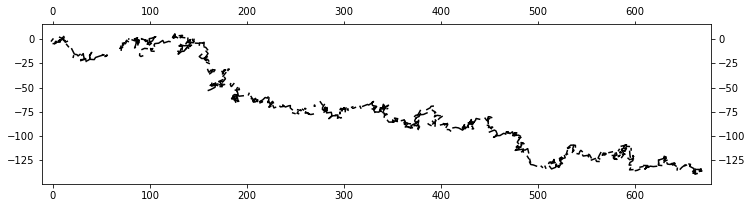

iteration: 1550 of 39000, avg_loss: 1791.02, timeSinceStart: 461.99, Epoch: 39
iteration: 1600 of 39000, avg_loss: 1789.68, timeSinceStart: 476.91, Epoch: 41
iteration: 1650 of 39000, avg_loss: 1781.03, timeSinceStart: 491.81, Epoch: 42
iteration: 1700 of 39000, avg_loss: 1775.44, timeSinceStart: 506.77, Epoch: 43
iteration: 1750 of 39000, avg_loss: 1771.94, timeSinceStart: 521.88, Epoch: 44


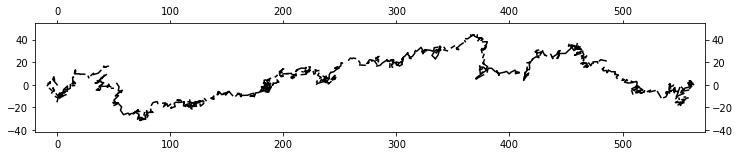

iteration: 1800 of 39000, avg_loss: 1762.35, timeSinceStart: 538.43, Epoch: 46
iteration: 1850 of 39000, avg_loss: 1757.80, timeSinceStart: 553.45, Epoch: 47
iteration: 1900 of 39000, avg_loss: 1750.72, timeSinceStart: 568.31, Epoch: 48
iteration: 1950 of 39000, avg_loss: 1744.85, timeSinceStart: 583.17, Epoch: 50
iteration: 2000 of 39000, avg_loss: 1737.98, timeSinceStart: 598.05, Epoch: 51


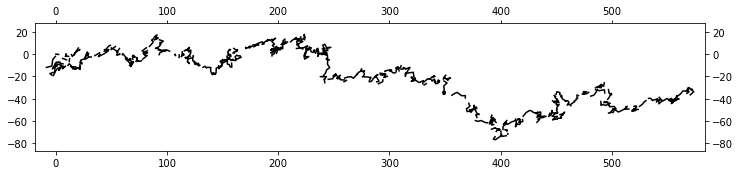

iteration: 2050 of 39000, avg_loss: 1714.87, timeSinceStart: 614.24, Epoch: 52
iteration: 2100 of 39000, avg_loss: 1717.59, timeSinceStart: 629.15, Epoch: 53
iteration: 2150 of 39000, avg_loss: 1712.20, timeSinceStart: 644.13, Epoch: 55
iteration: 2200 of 39000, avg_loss: 1706.57, timeSinceStart: 659.14, Epoch: 56
iteration: 2250 of 39000, avg_loss: 1704.54, timeSinceStart: 674.11, Epoch: 57


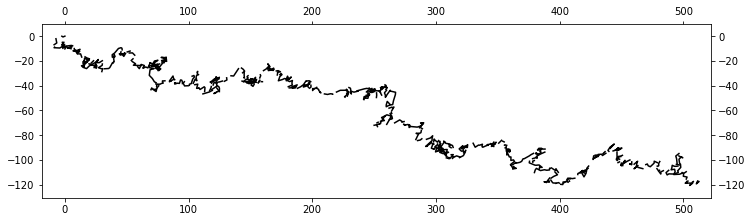

iteration: 2300 of 39000, avg_loss: 1695.86, timeSinceStart: 690.46, Epoch: 58
iteration: 2350 of 39000, avg_loss: 1693.10, timeSinceStart: 705.38, Epoch: 60
iteration: 2400 of 39000, avg_loss: 1685.26, timeSinceStart: 720.32, Epoch: 61
iteration: 2450 of 39000, avg_loss: 1683.26, timeSinceStart: 735.18, Epoch: 62
iteration: 2500 of 39000, avg_loss: 1680.61, timeSinceStart: 750.19, Epoch: 64


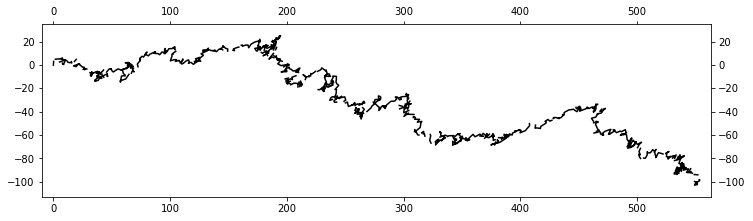

iteration: 2550 of 39000, avg_loss: 1673.93, timeSinceStart: 766.51, Epoch: 65
iteration: 2600 of 39000, avg_loss: 1673.44, timeSinceStart: 781.46, Epoch: 66
iteration: 2650 of 39000, avg_loss: 1665.69, timeSinceStart: 796.45, Epoch: 67
iteration: 2700 of 39000, avg_loss: 1668.16, timeSinceStart: 811.42, Epoch: 69
iteration: 2750 of 39000, avg_loss: 1660.19, timeSinceStart: 826.50, Epoch: 70


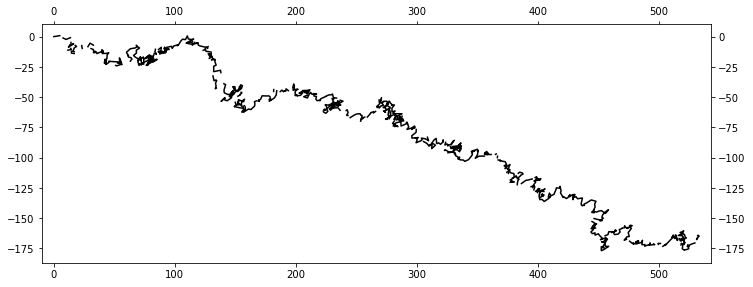

iteration: 2800 of 39000, avg_loss: 1653.49, timeSinceStart: 842.79, Epoch: 71
iteration: 2850 of 39000, avg_loss: 1654.13, timeSinceStart: 857.78, Epoch: 73
iteration: 2900 of 39000, avg_loss: 1649.53, timeSinceStart: 872.93, Epoch: 74
iteration: 2950 of 39000, avg_loss: 1642.81, timeSinceStart: 887.96, Epoch: 75
iteration: 3000 of 39000, avg_loss: 1641.95, timeSinceStart: 902.88, Epoch: 76


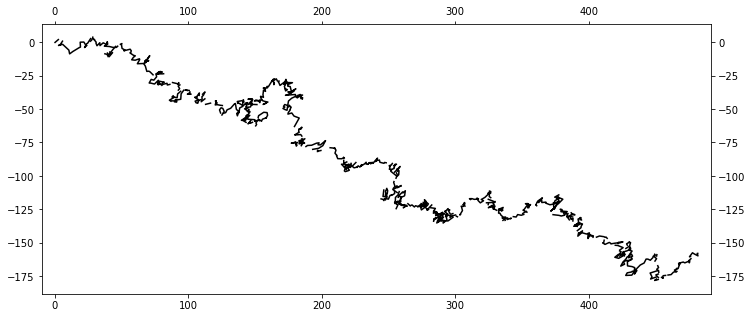

iteration: 3050 of 39000, avg_loss: 1640.56, timeSinceStart: 919.13, Epoch: 78
iteration: 3100 of 39000, avg_loss: 1634.19, timeSinceStart: 934.03, Epoch: 79
iteration: 3150 of 39000, avg_loss: 1629.53, timeSinceStart: 948.90, Epoch: 80
iteration: 3200 of 39000, avg_loss: 1626.83, timeSinceStart: 963.80, Epoch: 82
iteration: 3250 of 39000, avg_loss: 1623.92, timeSinceStart: 978.78, Epoch: 83


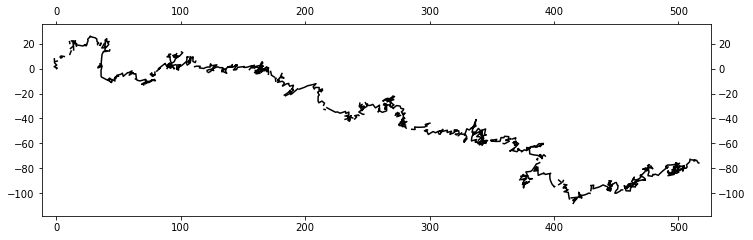

iteration: 3300 of 39000, avg_loss: 1619.85, timeSinceStart: 995.11, Epoch: 84
iteration: 3350 of 39000, avg_loss: 1618.26, timeSinceStart: 1009.99, Epoch: 85
iteration: 3400 of 39000, avg_loss: 1632.23, timeSinceStart: 1024.94, Epoch: 87
iteration: 3450 of 39000, avg_loss: 1617.91, timeSinceStart: 1039.82, Epoch: 88
iteration: 3500 of 39000, avg_loss: 1620.38, timeSinceStart: 1054.80, Epoch: 89


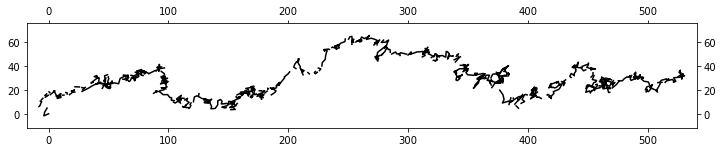

iteration: 3550 of 39000, avg_loss: 1614.07, timeSinceStart: 1071.02, Epoch: 91
iteration: 3600 of 39000, avg_loss: 1607.45, timeSinceStart: 1086.02, Epoch: 92
iteration: 3650 of 39000, avg_loss: 1601.64, timeSinceStart: 1100.92, Epoch: 93
iteration: 3700 of 39000, avg_loss: 1591.01, timeSinceStart: 1115.85, Epoch: 94
iteration: 3750 of 39000, avg_loss: 1592.45, timeSinceStart: 1130.84, Epoch: 96


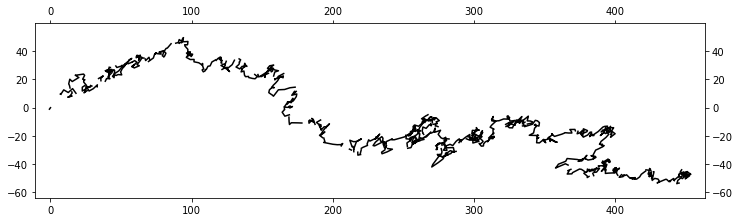

iteration: 3800 of 39000, avg_loss: 1588.57, timeSinceStart: 1147.11, Epoch: 97
iteration: 3850 of 39000, avg_loss: 1592.10, timeSinceStart: 1162.10, Epoch: 98
iteration: 3900 of 39000, avg_loss: 1575.59, timeSinceStart: 1177.14, Epoch: 100
iteration: 3950 of 39000, avg_loss: 1582.38, timeSinceStart: 1192.08, Epoch: 101
iteration: 4000 of 39000, avg_loss: 1567.67, timeSinceStart: 1206.99, Epoch: 102


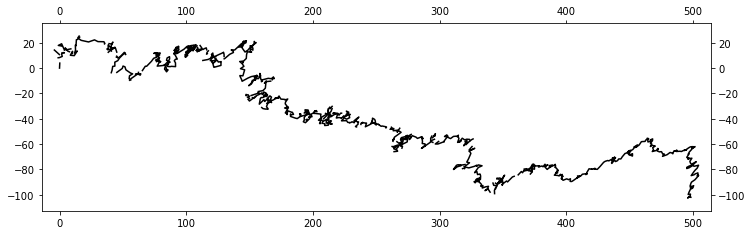

iteration: 4050 of 39000, avg_loss: 1582.65, timeSinceStart: 1223.13, Epoch: 103
iteration: 4100 of 39000, avg_loss: 1561.44, timeSinceStart: 1238.06, Epoch: 105
iteration: 4150 of 39000, avg_loss: 1554.25, timeSinceStart: 1253.08, Epoch: 106
iteration: 4200 of 39000, avg_loss: 1568.41, timeSinceStart: 1268.07, Epoch: 107
iteration: 4250 of 39000, avg_loss: 1590.95, timeSinceStart: 1283.08, Epoch: 108


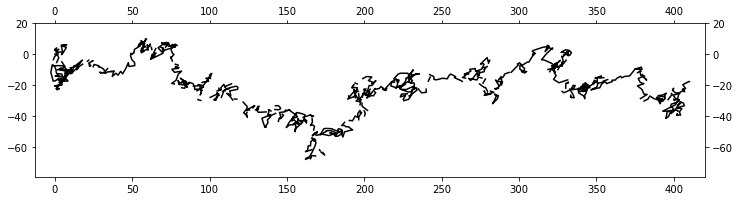

iteration: 4300 of 39000, avg_loss: 1570.25, timeSinceStart: 1299.46, Epoch: 110
iteration: 4350 of 39000, avg_loss: 1548.05, timeSinceStart: 1314.47, Epoch: 111
iteration: 4400 of 39000, avg_loss: 1560.46, timeSinceStart: 1329.51, Epoch: 112
iteration: 4450 of 39000, avg_loss: 1549.42, timeSinceStart: 1344.57, Epoch: 114
iteration: 4500 of 39000, avg_loss: 1546.70, timeSinceStart: 1359.52, Epoch: 115


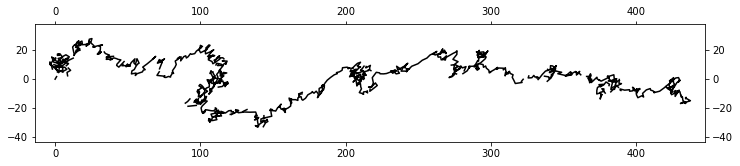

iteration: 4550 of 39000, avg_loss: 1549.52, timeSinceStart: 1375.70, Epoch: 116
iteration: 4600 of 39000, avg_loss: 1535.03, timeSinceStart: 1390.60, Epoch: 117
iteration: 4650 of 39000, avg_loss: 1516.52, timeSinceStart: 1405.46, Epoch: 119
iteration: 4700 of 39000, avg_loss: 1513.14, timeSinceStart: 1420.38, Epoch: 120
iteration: 4750 of 39000, avg_loss: 1506.16, timeSinceStart: 1435.44, Epoch: 121


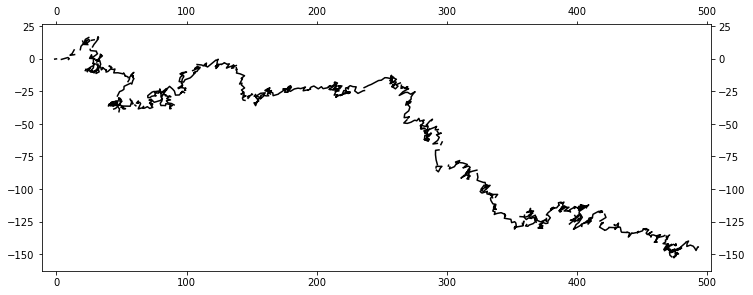

iteration: 4800 of 39000, avg_loss: 1501.48, timeSinceStart: 1451.65, Epoch: 123
iteration: 4850 of 39000, avg_loss: 1495.14, timeSinceStart: 1466.50, Epoch: 124
iteration: 4900 of 39000, avg_loss: 1489.85, timeSinceStart: 1481.45, Epoch: 125
iteration: 4950 of 39000, avg_loss: 1495.67, timeSinceStart: 1496.45, Epoch: 126
iteration: 5000 of 39000, avg_loss: 1482.83, timeSinceStart: 1511.46, Epoch: 128


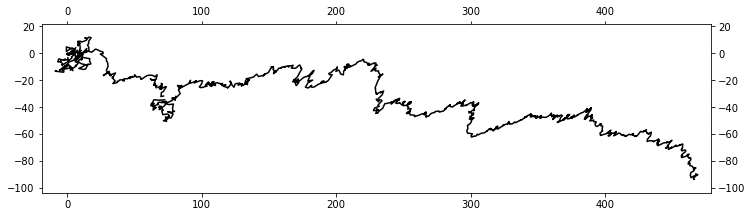

iteration: 5050 of 39000, avg_loss: 1479.59, timeSinceStart: 1527.53, Epoch: 129
iteration: 5100 of 39000, avg_loss: 1472.50, timeSinceStart: 1542.44, Epoch: 130
iteration: 5150 of 39000, avg_loss: 1470.62, timeSinceStart: 1557.39, Epoch: 132
iteration: 5200 of 39000, avg_loss: 1468.11, timeSinceStart: 1572.28, Epoch: 133
iteration: 5250 of 39000, avg_loss: 1477.59, timeSinceStart: 1587.26, Epoch: 134


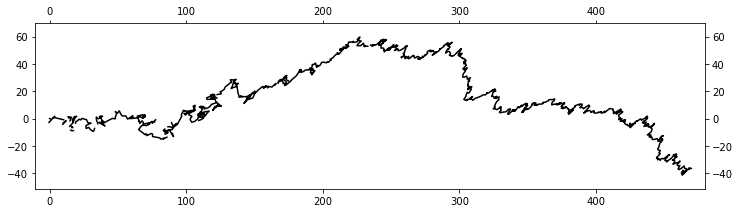

iteration: 5300 of 39000, avg_loss: 1453.32, timeSinceStart: 1603.45, Epoch: 135
iteration: 5350 of 39000, avg_loss: 1449.32, timeSinceStart: 1618.55, Epoch: 137
iteration: 5400 of 39000, avg_loss: 1455.42, timeSinceStart: 1633.48, Epoch: 138
iteration: 5450 of 39000, avg_loss: 1452.54, timeSinceStart: 1648.39, Epoch: 139
iteration: 5500 of 39000, avg_loss: 1445.56, timeSinceStart: 1663.43, Epoch: 141


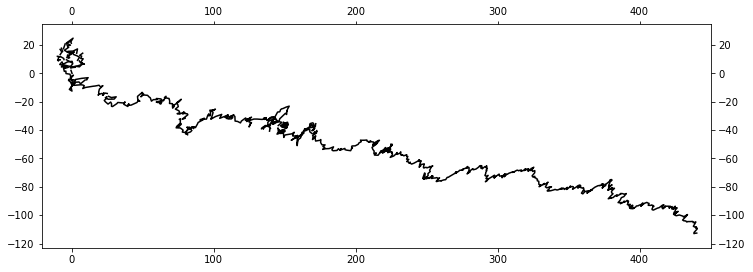

iteration: 5550 of 39000, avg_loss: 1436.57, timeSinceStart: 1679.67, Epoch: 142
iteration: 5600 of 39000, avg_loss: 1428.97, timeSinceStart: 1694.64, Epoch: 143
iteration: 5650 of 39000, avg_loss: 1418.43, timeSinceStart: 1709.51, Epoch: 144
iteration: 5700 of 39000, avg_loss: 1418.81, timeSinceStart: 1724.46, Epoch: 146
iteration: 5750 of 39000, avg_loss: 1411.14, timeSinceStart: 1739.51, Epoch: 147


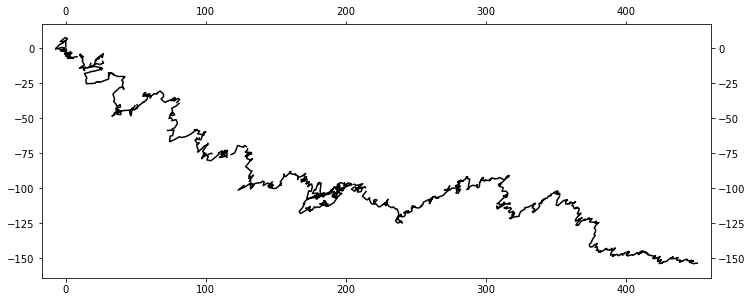

iteration: 5800 of 39000, avg_loss: 1411.72, timeSinceStart: 1755.87, Epoch: 148
iteration: 5850 of 39000, avg_loss: 1407.40, timeSinceStart: 1770.93, Epoch: 150
iteration: 5900 of 39000, avg_loss: 1392.27, timeSinceStart: 1786.01, Epoch: 151
iteration: 5950 of 39000, avg_loss: 1391.38, timeSinceStart: 1801.16, Epoch: 152
iteration: 6000 of 39000, avg_loss: 1392.94, timeSinceStart: 1816.47, Epoch: 153


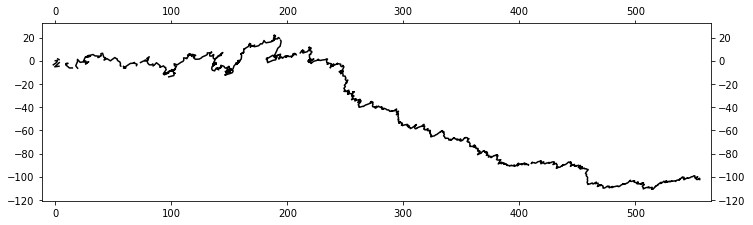

iteration: 6050 of 39000, avg_loss: 1376.65, timeSinceStart: 1832.99, Epoch: 155
iteration: 6100 of 39000, avg_loss: 1416.12, timeSinceStart: 1848.27, Epoch: 156
iteration: 6150 of 39000, avg_loss: 1373.56, timeSinceStart: 1863.55, Epoch: 157
iteration: 6200 of 39000, avg_loss: 1349.93, timeSinceStart: 1878.83, Epoch: 158
iteration: 6250 of 39000, avg_loss: 1360.01, timeSinceStart: 1894.04, Epoch: 160


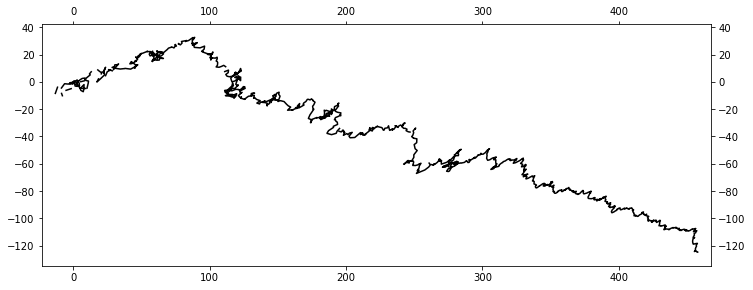

iteration: 6300 of 39000, avg_loss: 1346.03, timeSinceStart: 1910.48, Epoch: 161
iteration: 6350 of 39000, avg_loss: 1359.14, timeSinceStart: 1925.72, Epoch: 162
iteration: 6400 of 39000, avg_loss: 1384.64, timeSinceStart: 1940.87, Epoch: 164
iteration: 6450 of 39000, avg_loss: 1431.31, timeSinceStart: 1955.88, Epoch: 165
iteration: 6500 of 39000, avg_loss: 1332.02, timeSinceStart: 1971.08, Epoch: 166


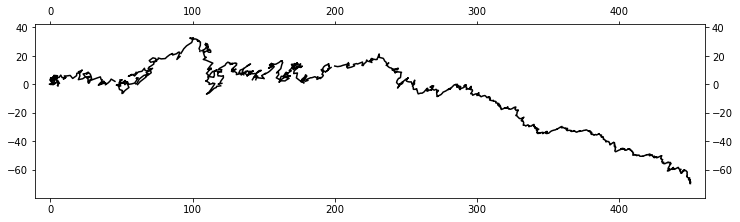

iteration: 6550 of 39000, avg_loss: 1361.42, timeSinceStart: 1987.45, Epoch: 167
iteration: 6600 of 39000, avg_loss: 1442.79, timeSinceStart: 2002.58, Epoch: 169
iteration: 6650 of 39000, avg_loss: 1369.30, timeSinceStart: 2017.71, Epoch: 170
iteration: 6700 of 39000, avg_loss: 1300.76, timeSinceStart: 2032.83, Epoch: 171
iteration: 6750 of 39000, avg_loss: 1421.73, timeSinceStart: 2048.05, Epoch: 173


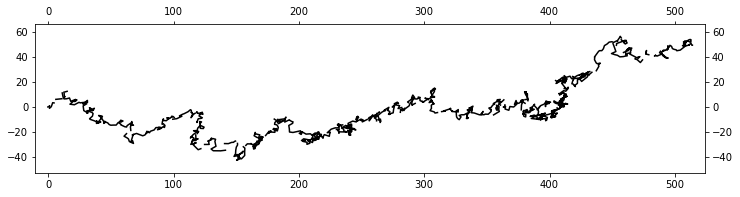

iteration: 6800 of 39000, avg_loss: 1373.34, timeSinceStart: 2064.35, Epoch: 174
iteration: 6850 of 39000, avg_loss: 1293.07, timeSinceStart: 2079.40, Epoch: 175
iteration: 6900 of 39000, avg_loss: 1377.73, timeSinceStart: 2094.61, Epoch: 176
iteration: 6950 of 39000, avg_loss: 1363.42, timeSinceStart: 2109.69, Epoch: 178
iteration: 7000 of 39000, avg_loss: 1272.12, timeSinceStart: 2124.81, Epoch: 179


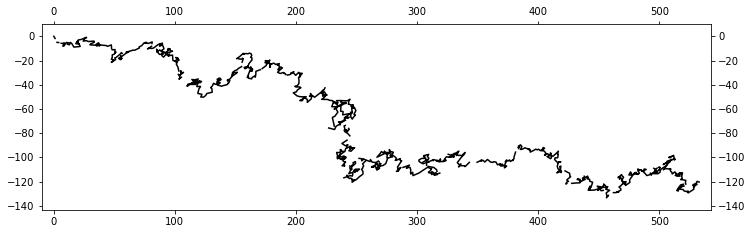

iteration: 7050 of 39000, avg_loss: 1384.64, timeSinceStart: 2141.44, Epoch: 180
iteration: 7100 of 39000, avg_loss: 1284.97, timeSinceStart: 2156.59, Epoch: 182
iteration: 7150 of 39000, avg_loss: 1347.62, timeSinceStart: 2171.78, Epoch: 183
iteration: 7200 of 39000, avg_loss: 1248.61, timeSinceStart: 2187.01, Epoch: 184
iteration: 7250 of 39000, avg_loss: 1285.96, timeSinceStart: 2202.16, Epoch: 185


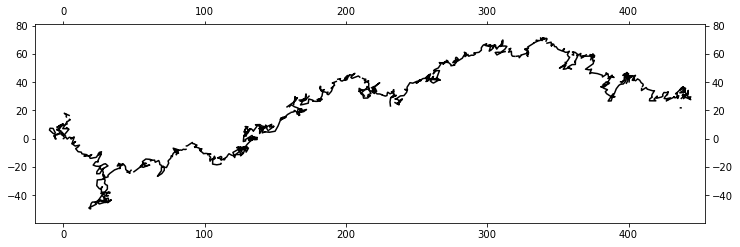

iteration: 7300 of 39000, avg_loss: 1284.66, timeSinceStart: 2218.71, Epoch: 187
iteration: 7350 of 39000, avg_loss: 1297.80, timeSinceStart: 2234.02, Epoch: 188
iteration: 7400 of 39000, avg_loss: 1332.49, timeSinceStart: 2249.23, Epoch: 189
iteration: 7450 of 39000, avg_loss: 1399.43, timeSinceStart: 2264.45, Epoch: 191
iteration: 7500 of 39000, avg_loss: 1359.74, timeSinceStart: 2279.56, Epoch: 192


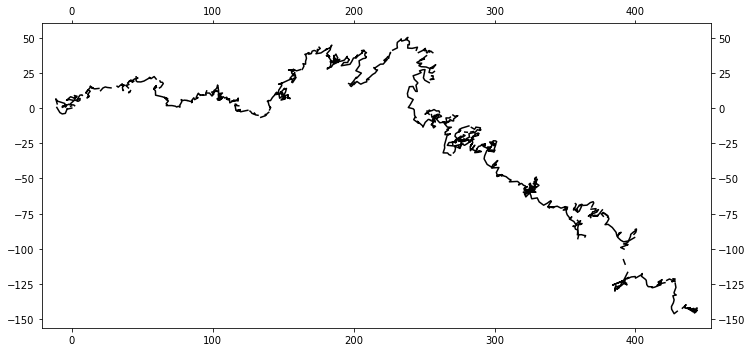

iteration: 7550 of 39000, avg_loss: 1323.30, timeSinceStart: 2296.19, Epoch: 193
iteration: 7600 of 39000, avg_loss: 1286.55, timeSinceStart: 2311.41, Epoch: 194
iteration: 7650 of 39000, avg_loss: 1242.54, timeSinceStart: 2326.54, Epoch: 196
iteration: 7700 of 39000, avg_loss: 1262.99, timeSinceStart: 2341.55, Epoch: 197
iteration: 7750 of 39000, avg_loss: 1230.11, timeSinceStart: 2356.73, Epoch: 198


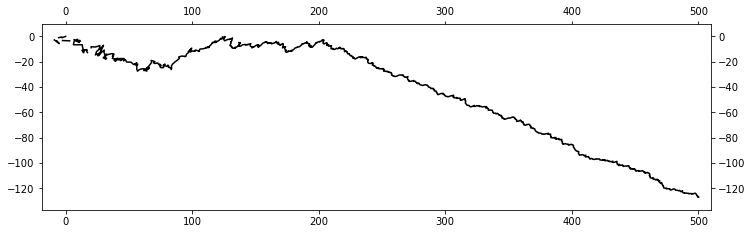

iteration: 7800 of 39000, avg_loss: 1268.16, timeSinceStart: 2373.07, Epoch: 200
iteration: 7850 of 39000, avg_loss: 1319.04, timeSinceStart: 2388.21, Epoch: 201
iteration: 7900 of 39000, avg_loss: 1253.35, timeSinceStart: 2403.29, Epoch: 202
iteration: 7950 of 39000, avg_loss: 1156.47, timeSinceStart: 2418.46, Epoch: 203
iteration: 8000 of 39000, avg_loss: 1154.27, timeSinceStart: 2433.75, Epoch: 205


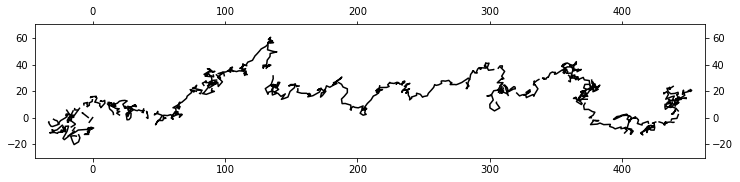

iteration: 8050 of 39000, avg_loss: 1397.94, timeSinceStart: 2450.21, Epoch: 206
iteration: 8100 of 39000, avg_loss: 1382.43, timeSinceStart: 2465.38, Epoch: 207
iteration: 8150 of 39000, avg_loss: 1354.09, timeSinceStart: 2480.44, Epoch: 208
iteration: 8200 of 39000, avg_loss: 1322.53, timeSinceStart: 2495.69, Epoch: 210
iteration: 8250 of 39000, avg_loss: 1288.30, timeSinceStart: 2510.88, Epoch: 211


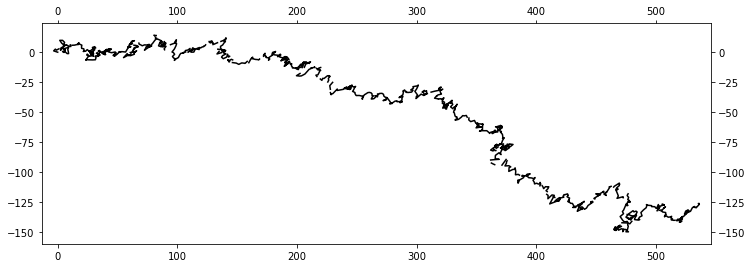

iteration: 8300 of 39000, avg_loss: 1264.89, timeSinceStart: 2527.31, Epoch: 212
iteration: 8350 of 39000, avg_loss: 1242.48, timeSinceStart: 2542.38, Epoch: 214
iteration: 8400 of 39000, avg_loss: 1231.66, timeSinceStart: 2557.68, Epoch: 215
iteration: 8450 of 39000, avg_loss: 1214.74, timeSinceStart: 2572.95, Epoch: 216
iteration: 8500 of 39000, avg_loss: 1206.83, timeSinceStart: 2588.16, Epoch: 217


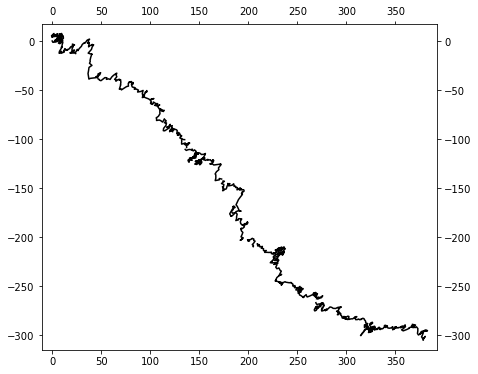

iteration: 8550 of 39000, avg_loss: 1192.01, timeSinceStart: 2604.38, Epoch: 219
iteration: 8600 of 39000, avg_loss: 1178.27, timeSinceStart: 2619.54, Epoch: 220
iteration: 8650 of 39000, avg_loss: 1114.55, timeSinceStart: 2634.72, Epoch: 221
iteration: 8700 of 39000, avg_loss: 1115.09, timeSinceStart: 2649.99, Epoch: 223
iteration: 8750 of 39000, avg_loss: 1327.66, timeSinceStart: 2665.06, Epoch: 224


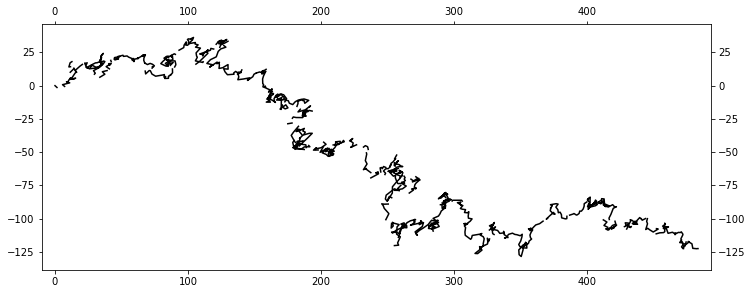

iteration: 8800 of 39000, avg_loss: 1292.27, timeSinceStart: 2681.54, Epoch: 225
iteration: 8850 of 39000, avg_loss: 1247.60, timeSinceStart: 2696.66, Epoch: 226
iteration: 8900 of 39000, avg_loss: 1205.92, timeSinceStart: 2711.91, Epoch: 228
iteration: 8950 of 39000, avg_loss: 1174.33, timeSinceStart: 2727.01, Epoch: 229
iteration: 9000 of 39000, avg_loss: 1152.81, timeSinceStart: 2742.30, Epoch: 230


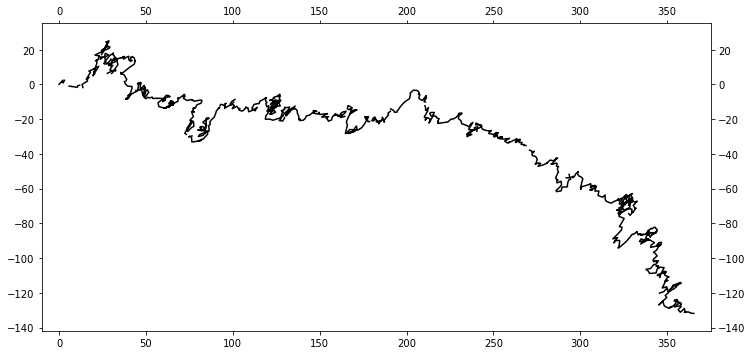

iteration: 9050 of 39000, avg_loss: 1142.54, timeSinceStart: 2758.79, Epoch: 232
iteration: 9100 of 39000, avg_loss: 1125.23, timeSinceStart: 2773.96, Epoch: 233
iteration: 9150 of 39000, avg_loss: 1114.22, timeSinceStart: 2789.10, Epoch: 234
iteration: 9200 of 39000, avg_loss: 1064.83, timeSinceStart: 2804.44, Epoch: 235
iteration: 9250 of 39000, avg_loss: 1022.59, timeSinceStart: 2819.75, Epoch: 237


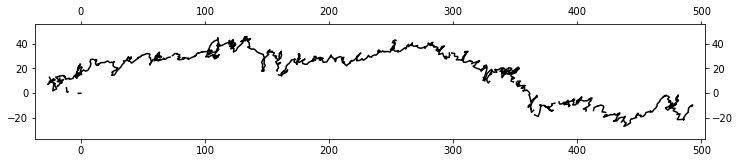

iteration: 9300 of 39000, avg_loss: 1013.76, timeSinceStart: 2836.06, Epoch: 238
iteration: 9350 of 39000, avg_loss: 1172.07, timeSinceStart: 2851.06, Epoch: 239
iteration: 9400 of 39000, avg_loss: 1335.66, timeSinceStart: 2866.37, Epoch: 241
iteration: 9450 of 39000, avg_loss: 1301.45, timeSinceStart: 2881.38, Epoch: 242
iteration: 9500 of 39000, avg_loss: 1283.82, timeSinceStart: 2896.66, Epoch: 243


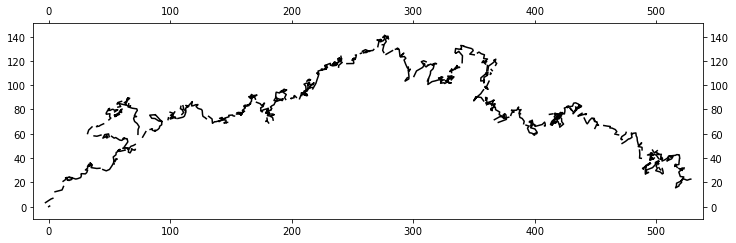

iteration: 9550 of 39000, avg_loss: 1247.01, timeSinceStart: 2913.14, Epoch: 244
iteration: 9600 of 39000, avg_loss: 1219.52, timeSinceStart: 2928.23, Epoch: 246
iteration: 9650 of 39000, avg_loss: 1198.72, timeSinceStart: 2943.45, Epoch: 247
iteration: 9700 of 39000, avg_loss: 1166.48, timeSinceStart: 2958.62, Epoch: 248
iteration: 9750 of 39000, avg_loss: 1149.09, timeSinceStart: 2973.82, Epoch: 250


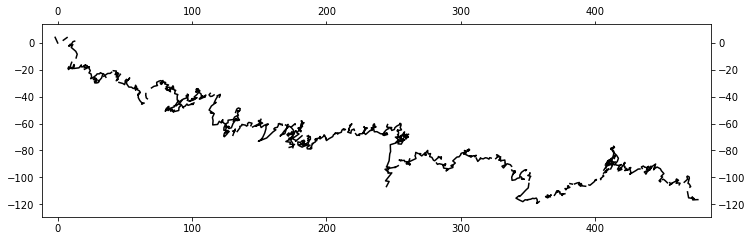

iteration: 9800 of 39000, avg_loss: 1124.61, timeSinceStart: 2990.27, Epoch: 251
iteration: 9850 of 39000, avg_loss: 1110.42, timeSinceStart: 3005.49, Epoch: 252
iteration: 9900 of 39000, avg_loss: 1095.96, timeSinceStart: 3020.75, Epoch: 253
iteration: 9950 of 39000, avg_loss: 1082.41, timeSinceStart: 3035.98, Epoch: 255
iteration: 10000 of 39000, avg_loss: 1073.22, timeSinceStart: 3051.13, Epoch: 256


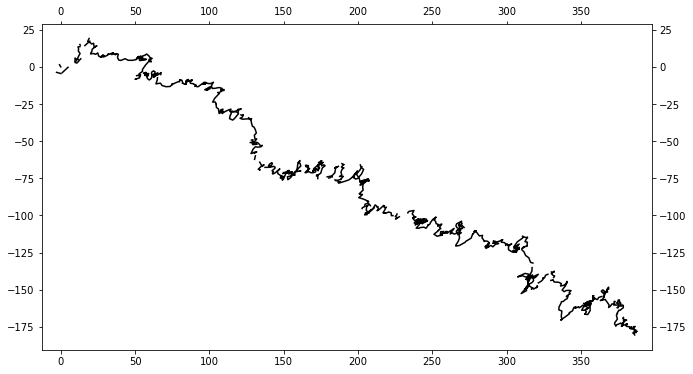

iteration: 10050 of 39000, avg_loss: 1062.46, timeSinceStart: 3067.65, Epoch: 257
iteration: 10100 of 39000, avg_loss: 1050.76, timeSinceStart: 3082.92, Epoch: 258
iteration: 10150 of 39000, avg_loss: 1039.17, timeSinceStart: 3098.16, Epoch: 260
iteration: 10200 of 39000, avg_loss: 1032.31, timeSinceStart: 3113.25, Epoch: 261
iteration: 10250 of 39000, avg_loss: 1019.50, timeSinceStart: 3128.47, Epoch: 262


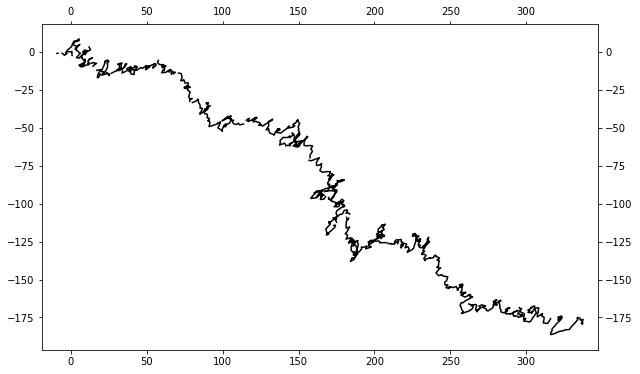

iteration: 10300 of 39000, avg_loss: 1005.74, timeSinceStart: 3145.04, Epoch: 264
iteration: 10350 of 39000, avg_loss: 999.68, timeSinceStart: 3160.22, Epoch: 265
iteration: 10400 of 39000, avg_loss: 981.43, timeSinceStart: 3175.38, Epoch: 266
iteration: 10450 of 39000, avg_loss: 975.07, timeSinceStart: 3190.52, Epoch: 267
iteration: 10500 of 39000, avg_loss: 958.80, timeSinceStart: 3205.78, Epoch: 269


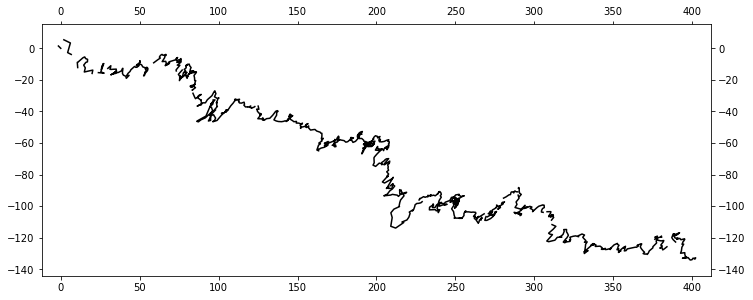

iteration: 10550 of 39000, avg_loss: 941.26, timeSinceStart: 3222.23, Epoch: 270
iteration: 10600 of 39000, avg_loss: 936.14, timeSinceStart: 3237.36, Epoch: 271
iteration: 10650 of 39000, avg_loss: 912.61, timeSinceStart: 3252.60, Epoch: 273
iteration: 10700 of 39000, avg_loss: 889.69, timeSinceStart: 3267.76, Epoch: 274
iteration: 10750 of 39000, avg_loss: 863.50, timeSinceStart: 3282.92, Epoch: 275


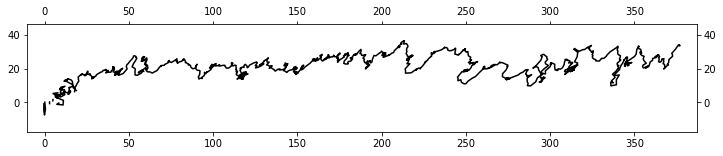

iteration: 10800 of 39000, avg_loss: 788.27, timeSinceStart: 3299.27, Epoch: 276
iteration: 10850 of 39000, avg_loss: 870.58, timeSinceStart: 3314.52, Epoch: 278
iteration: 10900 of 39000, avg_loss: 752.17, timeSinceStart: 3329.62, Epoch: 279
iteration: 10950 of 39000, avg_loss: 812.28, timeSinceStart: 3344.77, Epoch: 280
iteration: 11000 of 39000, avg_loss: 828.49, timeSinceStart: 3360.12, Epoch: 282


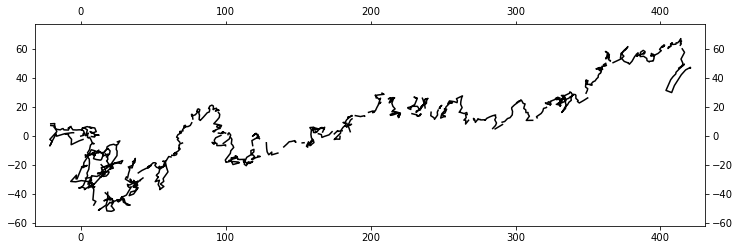

iteration: 11050 of 39000, avg_loss: 963.86, timeSinceStart: 3376.60, Epoch: 283
iteration: 11100 of 39000, avg_loss: 823.47, timeSinceStart: 3391.83, Epoch: 284
iteration: 11150 of 39000, avg_loss: 654.35, timeSinceStart: 3406.89, Epoch: 285
iteration: 11200 of 39000, avg_loss: 1154.80, timeSinceStart: 3422.02, Epoch: 287
iteration: 11250 of 39000, avg_loss: 1140.96, timeSinceStart: 3437.16, Epoch: 288


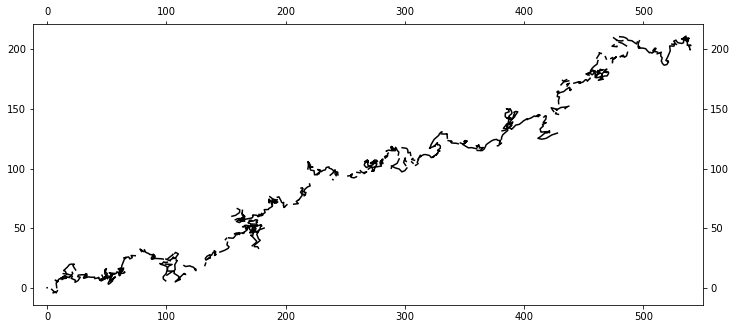

iteration: 11300 of 39000, avg_loss: 1096.67, timeSinceStart: 3453.69, Epoch: 289
iteration: 11350 of 39000, avg_loss: 1046.61, timeSinceStart: 3468.84, Epoch: 291
iteration: 11400 of 39000, avg_loss: 999.12, timeSinceStart: 3483.91, Epoch: 292
iteration: 11450 of 39000, avg_loss: 953.95, timeSinceStart: 3499.00, Epoch: 293
iteration: 11500 of 39000, avg_loss: 912.23, timeSinceStart: 3514.24, Epoch: 294


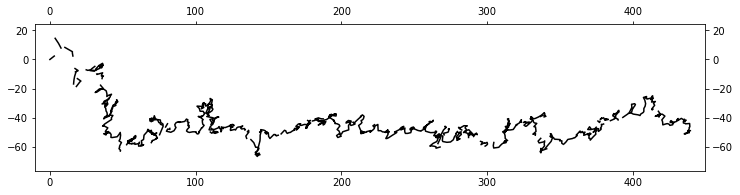

iteration: 11550 of 39000, avg_loss: 874.83, timeSinceStart: 3530.72, Epoch: 296
iteration: 11600 of 39000, avg_loss: 851.01, timeSinceStart: 3545.86, Epoch: 297
iteration: 11650 of 39000, avg_loss: 834.05, timeSinceStart: 3560.97, Epoch: 298
iteration: 11700 of 39000, avg_loss: 823.90, timeSinceStart: 3576.19, Epoch: 300
iteration: 11750 of 39000, avg_loss: 811.27, timeSinceStart: 3591.29, Epoch: 301


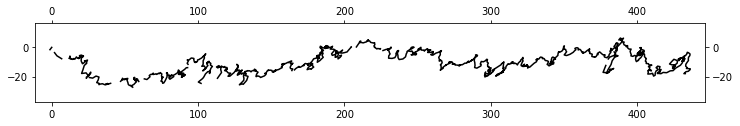

iteration: 11800 of 39000, avg_loss: 799.44, timeSinceStart: 3607.58, Epoch: 302
iteration: 11850 of 39000, avg_loss: 790.99, timeSinceStart: 3622.69, Epoch: 303
iteration: 11900 of 39000, avg_loss: 778.78, timeSinceStart: 3637.86, Epoch: 305
iteration: 11950 of 39000, avg_loss: 763.65, timeSinceStart: 3653.15, Epoch: 306
iteration: 12000 of 39000, avg_loss: 753.72, timeSinceStart: 3668.35, Epoch: 307


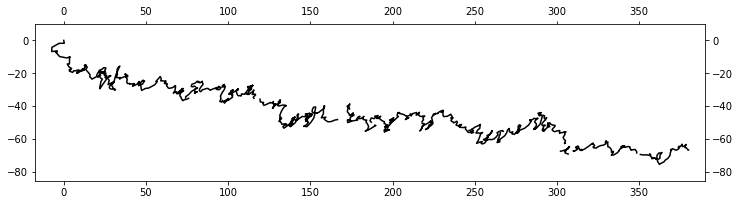

iteration: 12050 of 39000, avg_loss: 742.52, timeSinceStart: 3684.66, Epoch: 308
iteration: 12100 of 39000, avg_loss: 727.51, timeSinceStart: 3699.89, Epoch: 310
iteration: 12150 of 39000, avg_loss: 715.46, timeSinceStart: 3714.97, Epoch: 311
iteration: 12200 of 39000, avg_loss: 692.55, timeSinceStart: 3730.13, Epoch: 312
iteration: 12250 of 39000, avg_loss: 667.53, timeSinceStart: 3745.28, Epoch: 314


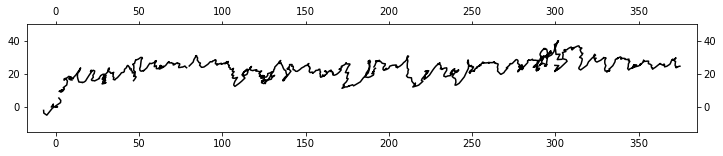

iteration: 12300 of 39000, avg_loss: 553.75, timeSinceStart: 3761.65, Epoch: 315
iteration: 12350 of 39000, avg_loss: 688.41, timeSinceStart: 3776.86, Epoch: 316
iteration: 12400 of 39000, avg_loss: 636.23, timeSinceStart: 3792.00, Epoch: 317
iteration: 12450 of 39000, avg_loss: 568.41, timeSinceStart: 3807.14, Epoch: 319
iteration: 12500 of 39000, avg_loss: 440.01, timeSinceStart: 3822.33, Epoch: 320


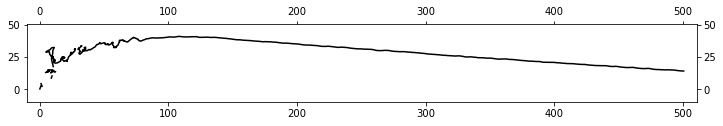

iteration: 12550 of 39000, avg_loss: 919.31, timeSinceStart: 3838.82, Epoch: 321
iteration: 12600 of 39000, avg_loss: 935.58, timeSinceStart: 3853.99, Epoch: 323
iteration: 12650 of 39000, avg_loss: 842.92, timeSinceStart: 3869.21, Epoch: 324
iteration: 12700 of 39000, avg_loss: 750.26, timeSinceStart: 3884.35, Epoch: 325
iteration: 12750 of 39000, avg_loss: 671.15, timeSinceStart: 3899.50, Epoch: 326


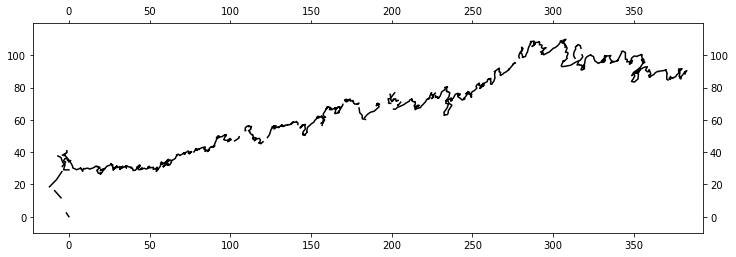

iteration: 12800 of 39000, avg_loss: 639.79, timeSinceStart: 3916.00, Epoch: 328
iteration: 12850 of 39000, avg_loss: 620.50, timeSinceStart: 3931.22, Epoch: 329
iteration: 12900 of 39000, avg_loss: 589.82, timeSinceStart: 3946.47, Epoch: 330
iteration: 12950 of 39000, avg_loss: 417.52, timeSinceStart: 3961.80, Epoch: 332
iteration: 13000 of 39000, avg_loss: 572.97, timeSinceStart: 3976.99, Epoch: 333


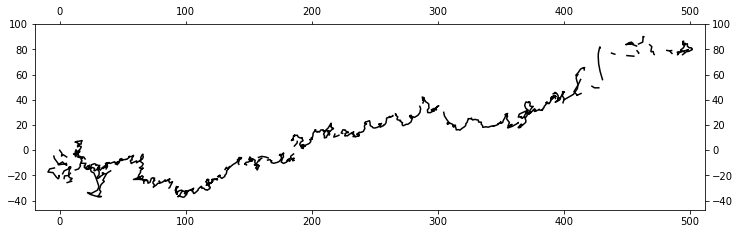

iteration: 13050 of 39000, avg_loss: 670.03, timeSinceStart: 3993.59, Epoch: 334
iteration: 13100 of 39000, avg_loss: 421.67, timeSinceStart: 4008.70, Epoch: 335
iteration: 13150 of 39000, avg_loss: 670.63, timeSinceStart: 4023.97, Epoch: 337
iteration: 13200 of 39000, avg_loss: 628.41, timeSinceStart: 4039.20, Epoch: 338
iteration: 13250 of 39000, avg_loss: 573.57, timeSinceStart: 4054.34, Epoch: 339


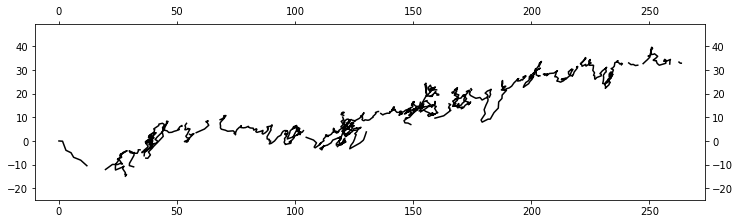

iteration: 13300 of 39000, avg_loss: 538.09, timeSinceStart: 4070.92, Epoch: 341
iteration: 13350 of 39000, avg_loss: 506.96, timeSinceStart: 4086.06, Epoch: 342
iteration: 13400 of 39000, avg_loss: 460.07, timeSinceStart: 4101.09, Epoch: 343
iteration: 13450 of 39000, avg_loss: 407.59, timeSinceStart: 4116.28, Epoch: 344
iteration: 13500 of 39000, avg_loss: 321.50, timeSinceStart: 4131.37, Epoch: 346


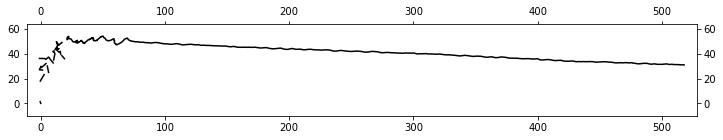

iteration: 13550 of 39000, avg_loss: 418.18, timeSinceStart: 4147.73, Epoch: 347
iteration: 13600 of 39000, avg_loss: 760.41, timeSinceStart: 4162.96, Epoch: 348
iteration: 13650 of 39000, avg_loss: 624.11, timeSinceStart: 4178.19, Epoch: 350
iteration: 13700 of 39000, avg_loss: 435.18, timeSinceStart: 4193.52, Epoch: 351
iteration: 13750 of 39000, avg_loss: 258.20, timeSinceStart: 4208.63, Epoch: 352


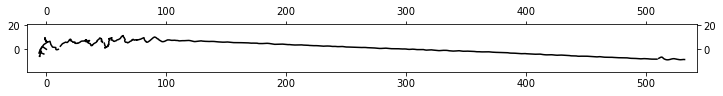

iteration: 13800 of 39000, avg_loss: 566.35, timeSinceStart: 4225.09, Epoch: 353
iteration: 13850 of 39000, avg_loss: 378.97, timeSinceStart: 4240.18, Epoch: 355
iteration: 13900 of 39000, avg_loss: 182.63, timeSinceStart: 4255.29, Epoch: 356
iteration: 13950 of 39000, avg_loss: 222.71, timeSinceStart: 4270.43, Epoch: 357
iteration: 14000 of 39000, avg_loss: 191.77, timeSinceStart: 4285.61, Epoch: 358


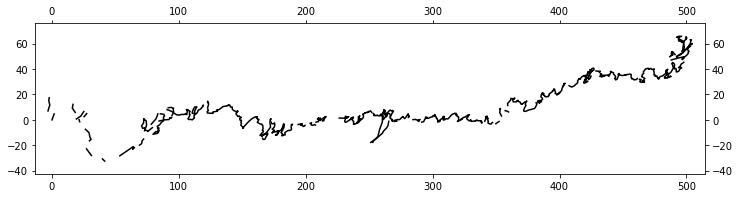

iteration: 14050 of 39000, avg_loss: 450.03, timeSinceStart: 4302.06, Epoch: 360
iteration: 14100 of 39000, avg_loss: 206.16, timeSinceStart: 4317.20, Epoch: 361
iteration: 14150 of 39000, avg_loss: 507.98, timeSinceStart: 4332.40, Epoch: 362
iteration: 14200 of 39000, avg_loss: 802.98, timeSinceStart: 4347.56, Epoch: 364
iteration: 14250 of 39000, avg_loss: 719.52, timeSinceStart: 4362.76, Epoch: 365


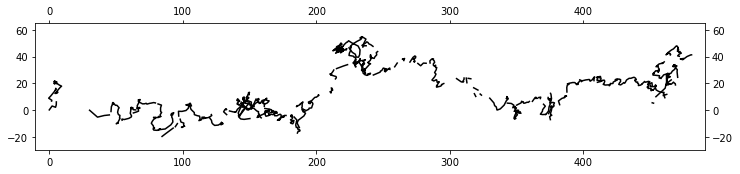

iteration: 14300 of 39000, avg_loss: 619.91, timeSinceStart: 4379.28, Epoch: 366
iteration: 14350 of 39000, avg_loss: 522.50, timeSinceStart: 4394.38, Epoch: 367
iteration: 14400 of 39000, avg_loss: 464.06, timeSinceStart: 4409.65, Epoch: 369
iteration: 14450 of 39000, avg_loss: 442.43, timeSinceStart: 4425.00, Epoch: 370
iteration: 14500 of 39000, avg_loss: 404.99, timeSinceStart: 4440.10, Epoch: 371


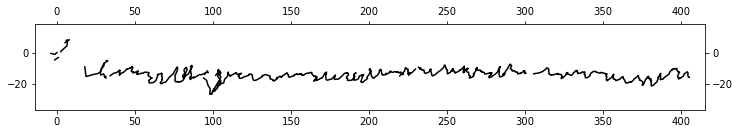

iteration: 14550 of 39000, avg_loss: 254.48, timeSinceStart: 4456.54, Epoch: 373
iteration: 14600 of 39000, avg_loss: 149.90, timeSinceStart: 4471.75, Epoch: 374
iteration: 14650 of 39000, avg_loss: 99.27, timeSinceStart: 4486.96, Epoch: 375
iteration: 14700 of 39000, avg_loss: 231.25, timeSinceStart: 4502.11, Epoch: 376
iteration: 14750 of 39000, avg_loss: 671.02, timeSinceStart: 4517.24, Epoch: 378


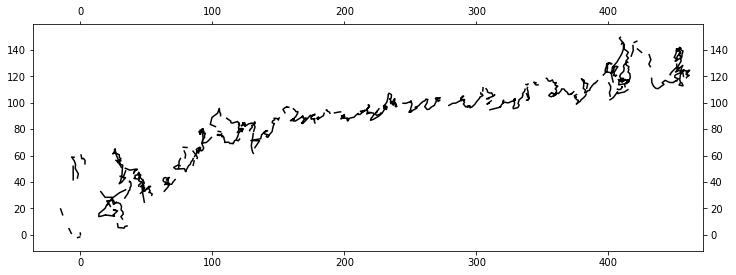

iteration: 14800 of 39000, avg_loss: 566.20, timeSinceStart: 4533.87, Epoch: 379
iteration: 14850 of 39000, avg_loss: 467.40, timeSinceStart: 4549.03, Epoch: 380
iteration: 14900 of 39000, avg_loss: 420.34, timeSinceStart: 4564.29, Epoch: 382
iteration: 14950 of 39000, avg_loss: 401.41, timeSinceStart: 4579.44, Epoch: 383
iteration: 15000 of 39000, avg_loss: 370.41, timeSinceStart: 4594.91, Epoch: 384


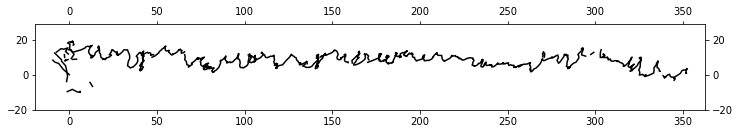

iteration: 15050 of 39000, avg_loss: 321.79, timeSinceStart: 4611.42, Epoch: 385
iteration: 15100 of 39000, avg_loss: 131.11, timeSinceStart: 4626.70, Epoch: 387
iteration: 15150 of 39000, avg_loss: 87.04, timeSinceStart: 4641.96, Epoch: 388
iteration: 15200 of 39000, avg_loss: 215.51, timeSinceStart: 4657.27, Epoch: 389
iteration: 15250 of 39000, avg_loss: 630.32, timeSinceStart: 4672.34, Epoch: 391


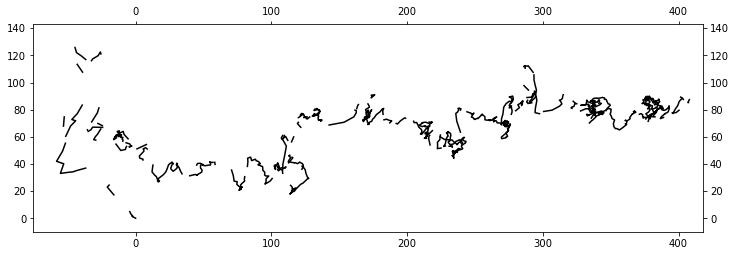

iteration: 15300 of 39000, avg_loss: 533.28, timeSinceStart: 4688.72, Epoch: 392
iteration: 15350 of 39000, avg_loss: 432.41, timeSinceStart: 4704.07, Epoch: 393
iteration: 15400 of 39000, avg_loss: 381.13, timeSinceStart: 4719.39, Epoch: 394
iteration: 15450 of 39000, avg_loss: 365.06, timeSinceStart: 4734.52, Epoch: 396
iteration: 15500 of 39000, avg_loss: 347.91, timeSinceStart: 4749.66, Epoch: 397


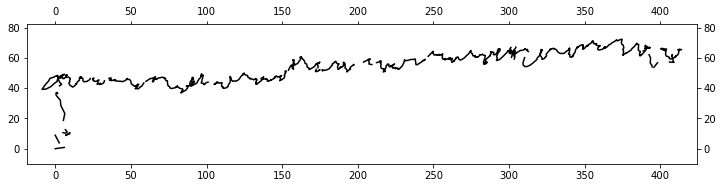

iteration: 15550 of 39000, avg_loss: 338.25, timeSinceStart: 4766.01, Epoch: 398
iteration: 15600 of 39000, avg_loss: 318.26, timeSinceStart: 4781.32, Epoch: 400
iteration: 15650 of 39000, avg_loss: 289.84, timeSinceStart: 4796.50, Epoch: 401
iteration: 15700 of 39000, avg_loss: 232.23, timeSinceStart: 4811.67, Epoch: 402
iteration: 15750 of 39000, avg_loss: 22.97, timeSinceStart: 4826.90, Epoch: 403


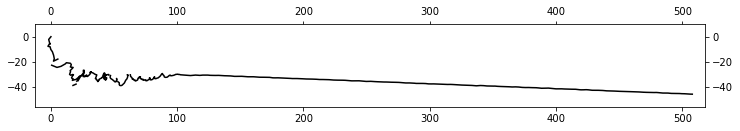

iteration: 15800 of 39000, avg_loss: 384.41, timeSinceStart: 4843.55, Epoch: 405
iteration: 15850 of 39000, avg_loss: 325.58, timeSinceStart: 4858.77, Epoch: 406
iteration: 15900 of 39000, avg_loss: 256.07, timeSinceStart: 4873.96, Epoch: 407
iteration: 15950 of 39000, avg_loss: 176.28, timeSinceStart: 4889.03, Epoch: 408
iteration: 16000 of 39000, avg_loss: 17.27, timeSinceStart: 4904.45, Epoch: 410


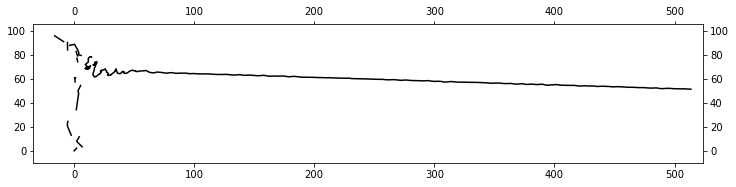

iteration: 16050 of 39000, avg_loss: -82.04, timeSinceStart: 4920.88, Epoch: 411
iteration: 16100 of 39000, avg_loss: 349.67, timeSinceStart: 4936.02, Epoch: 412
iteration: 16150 of 39000, avg_loss: 170.39, timeSinceStart: 4951.37, Epoch: 414
iteration: 16200 of 39000, avg_loss: -7.84, timeSinceStart: 4966.77, Epoch: 415
iteration: 16250 of 39000, avg_loss: -112.53, timeSinceStart: 4982.04, Epoch: 416


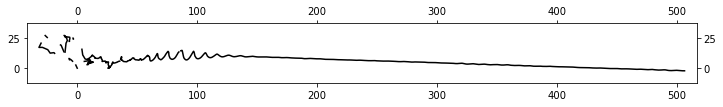

iteration: 16300 of 39000, avg_loss: 173.16, timeSinceStart: 4998.42, Epoch: 417
iteration: 16350 of 39000, avg_loss: 283.57, timeSinceStart: 5013.63, Epoch: 419
iteration: 16400 of 39000, avg_loss: 201.27, timeSinceStart: 5028.72, Epoch: 420
iteration: 16450 of 39000, avg_loss: 93.74, timeSinceStart: 5043.81, Epoch: 421
iteration: 16500 of 39000, avg_loss: -17.47, timeSinceStart: 5058.95, Epoch: 423


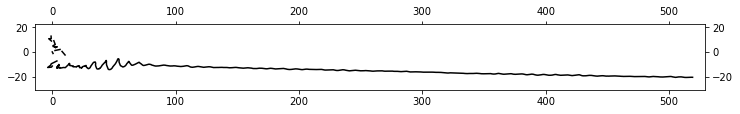

iteration: 16550 of 39000, avg_loss: -115.07, timeSinceStart: 5075.43, Epoch: 424
iteration: 16600 of 39000, avg_loss: -172.48, timeSinceStart: 5090.77, Epoch: 425
iteration: 16650 of 39000, avg_loss: 364.95, timeSinceStart: 5105.98, Epoch: 426
iteration: 16700 of 39000, avg_loss: 304.81, timeSinceStart: 5121.32, Epoch: 428
iteration: 16750 of 39000, avg_loss: 129.63, timeSinceStart: 5136.54, Epoch: 429


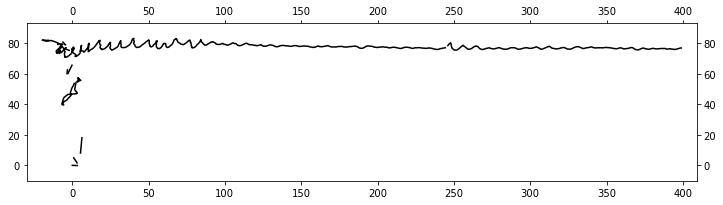

iteration: 16800 of 39000, avg_loss: -21.54, timeSinceStart: 5153.04, Epoch: 430
iteration: 16850 of 39000, avg_loss: -119.82, timeSinceStart: 5168.20, Epoch: 432
iteration: 16900 of 39000, avg_loss: -189.65, timeSinceStart: 5183.46, Epoch: 433
iteration: 16950 of 39000, avg_loss: -101.77, timeSinceStart: 5198.60, Epoch: 434
iteration: 17000 of 39000, avg_loss: -6.62, timeSinceStart: 5213.76, Epoch: 435


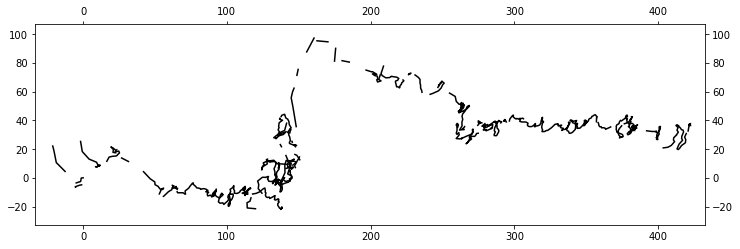

iteration: 17050 of 39000, avg_loss: 104.02, timeSinceStart: 5230.22, Epoch: 437
iteration: 17100 of 39000, avg_loss: -183.32, timeSinceStart: 5245.48, Epoch: 438
iteration: 17150 of 39000, avg_loss: -219.34, timeSinceStart: 5260.66, Epoch: 439
iteration: 17200 of 39000, avg_loss: 385.29, timeSinceStart: 5275.82, Epoch: 441
iteration: 17250 of 39000, avg_loss: 732.29, timeSinceStart: 5291.01, Epoch: 442


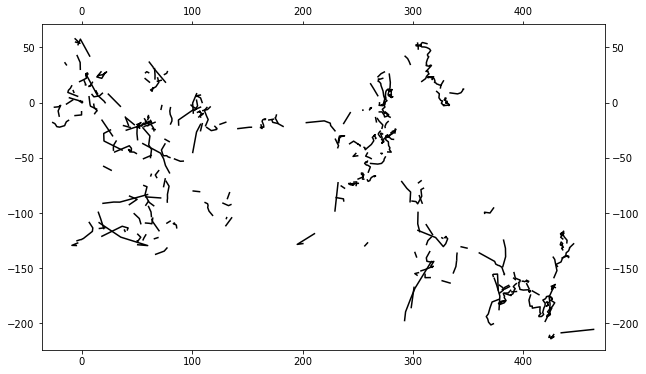

iteration: 17300 of 39000, avg_loss: 698.39, timeSinceStart: 5307.69, Epoch: 443
iteration: 17350 of 39000, avg_loss: 660.68, timeSinceStart: 5322.92, Epoch: 444
iteration: 17400 of 39000, avg_loss: 620.18, timeSinceStart: 5338.06, Epoch: 446
iteration: 17450 of 39000, avg_loss: 579.74, timeSinceStart: 5353.22, Epoch: 447
iteration: 17500 of 39000, avg_loss: 533.04, timeSinceStart: 5368.39, Epoch: 448


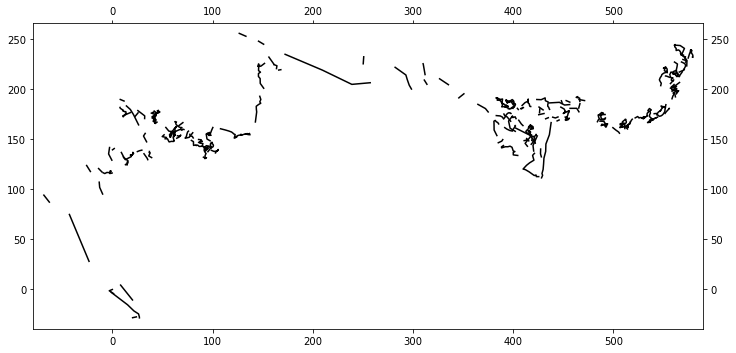

iteration: 17550 of 39000, avg_loss: 487.65, timeSinceStart: 5385.26, Epoch: 450
iteration: 17600 of 39000, avg_loss: 437.10, timeSinceStart: 5400.45, Epoch: 451
iteration: 17650 of 39000, avg_loss: 388.78, timeSinceStart: 5415.61, Epoch: 452
iteration: 17700 of 39000, avg_loss: 336.72, timeSinceStart: 5430.80, Epoch: 453
iteration: 17750 of 39000, avg_loss: 290.40, timeSinceStart: 5446.02, Epoch: 455


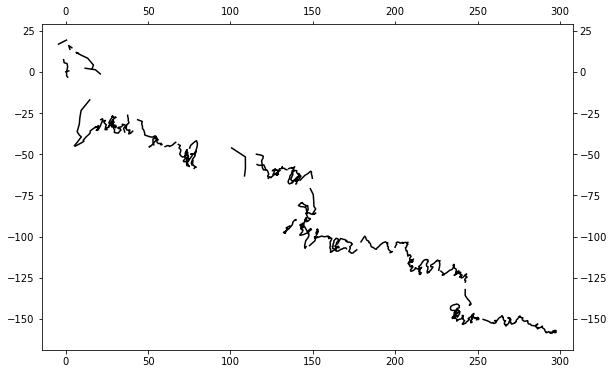

iteration: 17800 of 39000, avg_loss: 249.14, timeSinceStart: 5462.71, Epoch: 456
iteration: 17850 of 39000, avg_loss: 217.14, timeSinceStart: 5477.91, Epoch: 457
iteration: 17900 of 39000, avg_loss: 200.59, timeSinceStart: 5493.08, Epoch: 458
iteration: 17950 of 39000, avg_loss: 189.37, timeSinceStart: 5508.35, Epoch: 460
iteration: 18000 of 39000, avg_loss: 176.28, timeSinceStart: 5523.57, Epoch: 461


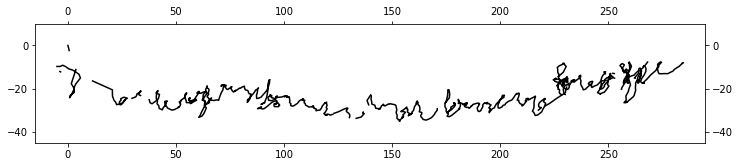

iteration: 18050 of 39000, avg_loss: 175.71, timeSinceStart: 5540.20, Epoch: 462
iteration: 18100 of 39000, avg_loss: 163.05, timeSinceStart: 5555.41, Epoch: 464
iteration: 18150 of 39000, avg_loss: 154.39, timeSinceStart: 5570.69, Epoch: 465
iteration: 18200 of 39000, avg_loss: 153.21, timeSinceStart: 5585.79, Epoch: 466
iteration: 18250 of 39000, avg_loss: 140.40, timeSinceStart: 5601.09, Epoch: 467


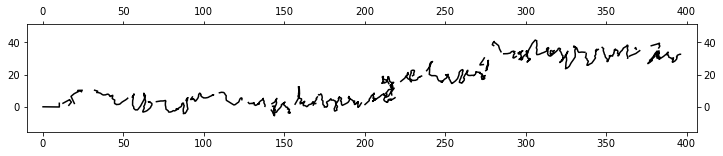

iteration: 18300 of 39000, avg_loss: 136.16, timeSinceStart: 5617.51, Epoch: 469
iteration: 18350 of 39000, avg_loss: 126.50, timeSinceStart: 5632.63, Epoch: 470
iteration: 18400 of 39000, avg_loss: 119.18, timeSinceStart: 5648.01, Epoch: 471
iteration: 18450 of 39000, avg_loss: 103.90, timeSinceStart: 5663.21, Epoch: 473
iteration: 18500 of 39000, avg_loss: 94.55, timeSinceStart: 5678.40, Epoch: 474


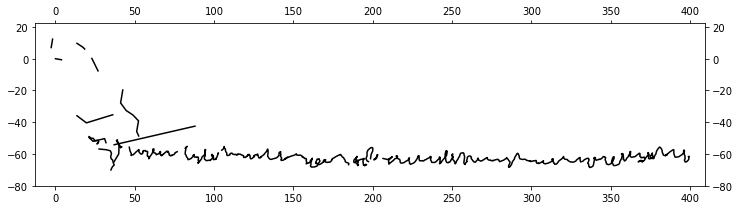

iteration: 18550 of 39000, avg_loss: 41.04, timeSinceStart: 5694.86, Epoch: 475
iteration: 18600 of 39000, avg_loss: -119.93, timeSinceStart: 5710.10, Epoch: 476
iteration: 18650 of 39000, avg_loss: -263.43, timeSinceStart: 5725.36, Epoch: 478
iteration: 18700 of 39000, avg_loss: 64.69, timeSinceStart: 5740.67, Epoch: 479
iteration: 18750 of 39000, avg_loss: -118.77, timeSinceStart: 5755.95, Epoch: 480


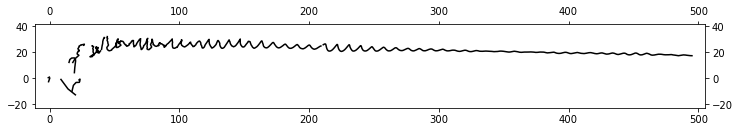

iteration: 18800 of 39000, avg_loss: -266.65, timeSinceStart: 5772.44, Epoch: 482
iteration: 18850 of 39000, avg_loss: -21.08, timeSinceStart: 5787.62, Epoch: 483
iteration: 18900 of 39000, avg_loss: 238.07, timeSinceStart: 5802.87, Epoch: 484
iteration: 18950 of 39000, avg_loss: 8.34, timeSinceStart: 5818.08, Epoch: 485
iteration: 19000 of 39000, avg_loss: -200.03, timeSinceStart: 5833.35, Epoch: 487


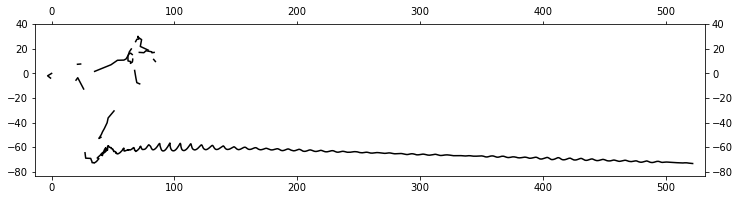

iteration: 19050 of 39000, avg_loss: -303.45, timeSinceStart: 5849.78, Epoch: 488
iteration: 19100 of 39000, avg_loss: -344.51, timeSinceStart: 5865.07, Epoch: 489
iteration: 19150 of 39000, avg_loss: -330.51, timeSinceStart: 5880.37, Epoch: 491
iteration: 19200 of 39000, avg_loss: -359.97, timeSinceStart: 5895.52, Epoch: 492
iteration: 19250 of 39000, avg_loss: -317.45, timeSinceStart: 5910.80, Epoch: 493


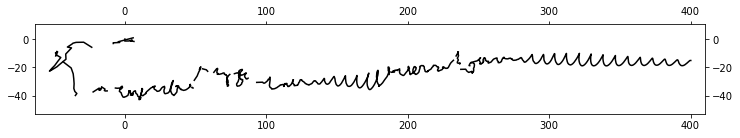

iteration: 19300 of 39000, avg_loss: 75.72, timeSinceStart: 5927.32, Epoch: 494
iteration: 19350 of 39000, avg_loss: 156.08, timeSinceStart: 5942.41, Epoch: 496
iteration: 19400 of 39000, avg_loss: 58.31, timeSinceStart: 5957.49, Epoch: 497
iteration: 19450 of 39000, avg_loss: 180.27, timeSinceStart: 5972.69, Epoch: 498
iteration: 19500 of 39000, avg_loss: 123.59, timeSinceStart: 5987.94, Epoch: 500


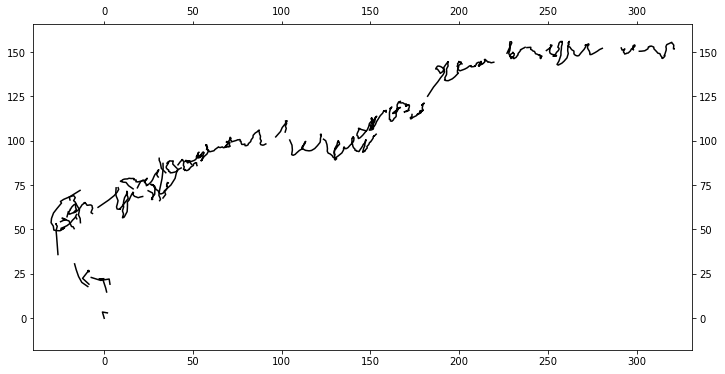

iteration: 19550 of 39000, avg_loss: 87.94, timeSinceStart: 6004.38, Epoch: 501
iteration: 19600 of 39000, avg_loss: 68.44, timeSinceStart: 6019.53, Epoch: 502
iteration: 19650 of 39000, avg_loss: 55.93, timeSinceStart: 6034.74, Epoch: 503
iteration: 19700 of 39000, avg_loss: 49.52, timeSinceStart: 6049.96, Epoch: 505
iteration: 19750 of 39000, avg_loss: 42.15, timeSinceStart: 6065.16, Epoch: 506


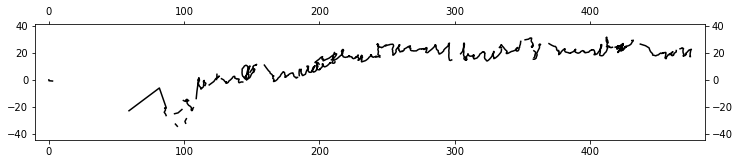

iteration: 19800 of 39000, avg_loss: 33.00, timeSinceStart: 6081.83, Epoch: 507
iteration: 19850 of 39000, avg_loss: 24.61, timeSinceStart: 6097.18, Epoch: 508
iteration: 19900 of 39000, avg_loss: 11.66, timeSinceStart: 6112.46, Epoch: 510
iteration: 19950 of 39000, avg_loss: 4.06, timeSinceStart: 6127.70, Epoch: 511
iteration: 20000 of 39000, avg_loss: -15.02, timeSinceStart: 6142.94, Epoch: 512


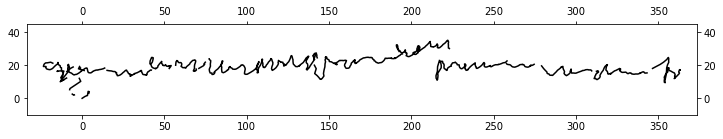

iteration: 20050 of 39000, avg_loss: -36.97, timeSinceStart: 6159.45, Epoch: 514
iteration: 20100 of 39000, avg_loss: -76.99, timeSinceStart: 6174.63, Epoch: 515
iteration: 20150 of 39000, avg_loss: -199.01, timeSinceStart: 6189.80, Epoch: 516
iteration: 20200 of 39000, avg_loss: -272.38, timeSinceStart: 6205.06, Epoch: 517
iteration: 20250 of 39000, avg_loss: -67.72, timeSinceStart: 6220.30, Epoch: 519


/tmp/ipykernel_3853/3508152864.py:23: RuntimeWarning: covariance is not positive-semidefinite.
  np.random.multivariate_normal(


ValueError: p < 0, p > 1 or p is NaN

In [15]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
